# 1-KOROKO ABDOULAYE
# 2-DIARASSOUBA SAKARIA

# Machine learning - ISUP3

Thanks to *Maxime Sangnier* for his help. 



## Decision trees and ensemble methods

In [192]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
from matplotlib import cm

def plotXY(X, Y):
    if Y.ndim > 1:
        X1 = X
        X2 = Y
        XX = np.concatenate((X, Y), axis=0)
        YY = np.concatenate((np.ones(X.shape[0]), -np.ones(Y.shape[0])))
    else:
        XX = X
        YY = Y
    for cl in np.unique(Y):
        plt.scatter(XX[YY==cl, 0], XX[YY==cl, 1])
    
def map_regions(clf, data=None, num=200):
    """
        Map the regions f(x)=1…K of the classifier clf within the same range as the one
        of the data.
        Input:
            clf: classifier with a method predict
            data: input data (X)
            num: discretization parameter
    """
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    z = clf.predict(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
    zmin, zmax = z.min(), z.max()
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cm.coolwarm,
              alpha=0.3)

In [194]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_pred, y, classes=None, normalize=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    cm = confusion_matrix(y, y_pred)
    
    if classes is None:
        classes = np.unique(y)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Unnormalized confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data generation

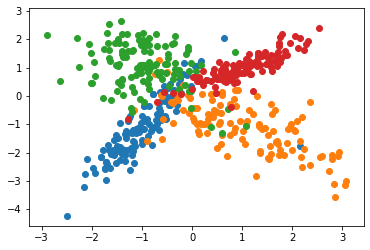

In [195]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_classes=4,
                           n_features=2, n_redundant=0, n_clusters_per_class=1)
plotXY(X, y)

### Decision trees

Decision trees, and in particular classification and regression trees (CART), are supervised estimators introduced by Leo Breiman et al.
The paradigm of a binary decision tree is to recursively split the space $\mathcal X$ with simple rules such that: is the explicative variable $x_j$ greater than the threshold $\tau$ or not?
Doing so, a decision tree is built, for which each node corresponds to a simple rule (and secondarly to a partition cell of $\mathcal X$).
The final result is a partition of $\mathcal X$ by hypercubes.

At each step of the learning algorithm, 

1. consider the partition $\mathcal P = \{\mathcal X\}$;
1. for each cell $\mathcal A$ of $\mathcal P$, define the two-cell partition
$\mathcal A = \mathcal L_{j, \tau} \cup \mathcal R_{j, \tau}$, where $j \in [d]$ is a feature index and $\tau \in \mathbb R$ is a threhold, and
$$
    \begin{cases}
        \mathcal L_{j, \tau} = \left\{ x \in \mathcal A :  x_j \le \tau \right\}\\
        \mathcal R_{j, \tau} = \left\{ x \in \mathcal A :  x_j > \tau \right\}
        %= \mathcal A \backslash \mathcal L_{j, \tau}.
    \end{cases}
$$
are the "left" and "right" parts of $\mathcal A$.
Then, find the best pair (feature, threhold) for splitting:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{\left| \mathcal L_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal L_{j, \tau}) +
    \frac{\left| \mathcal R_{j, \tau} \right|}{\left| \mathcal A \right|} D(\mathcal R_{j, \tau})
$$
where $D$ is a distortion measure for a cell (see below);
1. replace $\mathcal A$ by $\mathcal L_{j, \tau}$ and $\mathcal R_{j, \tau}$ in the partition $\mathcal P$;
1. go to 2.

Given a cell $\mathcal A$, one may define the ratio of observations of $\mathcal A$ of class $y \in \mathcal Y$:
$$
    p_y(\mathcal A) = \frac{\left| \left\{ i \in [n] : X_i \in \mathcal A, Y_i=y \right\} \right|}{\left| \mathcal A \right|}.
$$

Then, the distortion of the cell $\mathcal A$ may be:
- Gini impurity: $D(\mathcal A) = \sum_{y \in \mathcal Y} p_y(\mathcal A) (1-p_y(\mathcal A))$ (classification);
- entropy: $D(\mathcal A) = - \sum_{y \in \mathcal Y} p_y(\mathcal A) \log(p_y(\mathcal A))$ (classification);
- mean squared error: $D(\mathcal A) = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} \left( Y_i - \bar Y_{\mathcal A} \right)^2$, with $\bar Y_{\mathcal A} = \frac{1}{\left| \mathcal A \right|}\sum_{1 \le i \le n \atop X_i \in \mathcal A} Y_i$ (regression).

For regression, Jerome Friedman suggested an improved criterion (in its original paper tackling gradient boosting), referred to as Friedman's mean squared error:
$$
    (j, \tau) \in \operatorname{arg\,min}_{1 \le j \le d \atop \tau \in \mathbb R}
    \frac{ \left| \mathcal L_{j, \tau} \right| \left| \mathcal R_{j, \tau} \right| }{ \left| \mathcal L_{j, \tau} \right| + \left| \mathcal R_{j, \tau} \right| }
    \left( \bar Y_{\mathcal L_{j, \tau}} - \bar Y_{\mathcal R_{j, \tau}} \right)^2.
$$

Last but not least, several stopping rules are of interests:
- maximal depth of the tree;
- minimal number of observations required to split an internal node;
- minimal number of observations required to be at a leaf node;
- maximal number of leaf nodes.

We would like to assess the accuracy of a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) with respect to the kind of splitting criterion (Gini impurity or entropy) and to the maximal depth allowed.

For this purpose, fit a [classification tree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) on the previous dataset and plot 4 curves depicting the classification error for:
1. the train set and the Gini impurity;
1. the test set and the Gini impurity;
1. the train set and the entropy;
1. the test set and the entropy.

What can you conclude based on this numerical experiment?

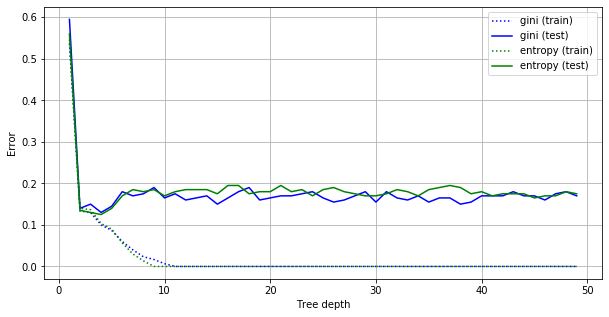

In [196]:
# Answer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

### TO BE COMPLETED
depths = [j for j in range(1,50)]
criteria=['gini','entropy']
############

train_err = []
test_err = []
for criterion in criteria:
    train_err.append([])  # New criteria => new list
    test_err.append([])
    for depth in depths:
        clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
        clf.fit(X_train, y_train)
        train_err[-1].append(1-clf.score(X_train, y_train))
        test_err[-1].append(1-clf.score(X_test, y_test))
        
plt.figure(figsize=(10, 5))
colors = "bgrc"
for ic, criterion in enumerate(criteria):
    plt.plot(depths, train_err[ic], color=colors[ic], linestyle=':',
             label=criterion+" (train)")
    plt.plot(depths, test_err[ic], color=colors[ic], linestyle='-',
             label=criterion+" (test)")
plt.xlabel("Tree depth")
plt.ylabel("Error")
plt.grid()
plt.legend(loc="best")

Map the regions of the "best" (with respect to the test error) decision tree obtained with the Gini impurity.

Best depth for gini criterion: 4.
Test error: 0.13


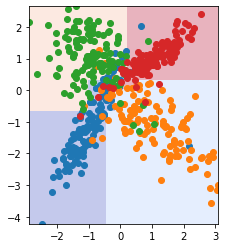

In [198]:
criterion = "gini"
ic = np.where([c == criterion for c in criteria])[0][0]  # Index for gini impurity
### TO BE COMPLETED
idepth = np.argmin(test_err[ic])
depth = depths[idepth]
###################
print("Best depth for {} criterion: {}.".format(criterion, depth))

# Fit the classifier with the best depth
clf = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
clf.fit(X_train, y_train)
print("Test error:", 1-clf.score(X_test, y_test))

plotXY(X, y)
map_regions(clf, X)

### Bagging

Bagging is a portmanteau word for *bootstrap aggregating*.
The paradigm of bagging is to train independently several base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, and to build a new classifier by averaging the predictions of the base classifiers:
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
Doing so, the variance of the prediction is reduced and so it is for the global error.
The requirements for such a result are:
- base classifiers should be more accurate than chance;
- base classifiers should be estimated independently from each other.

In practice, base classifiers are trained *quasi-independently* by bootstrapping the training set.

Bagging is also valid for multiclass problems: for $C$ classes, the prediction is:
$$
    g_n^T(x)
    = \operatorname{arg\,max}_{1 \le j \le C} \frac{1}{T} \sum_{t=1}^T g_t(x) \mathbb 1_{g_t(x)=j}
    = \operatorname{arg\,max}_{1 \le j \le C} \operatorname{card} \left( \left\{ t \in [T] : g_t(x) \mathbb 1_{g_t(x)=j} \right\} \right),
$$
where $g_t \colon \mathbb R^d \to [C]$, which corresponds to the majority vote since base classifiers are equally weighted.

Finally, one may also bag regressors $g_t \colon \mathbb R^d \to \mathbb R$ by a simple averaging:
$$
    g_n^T(x) = \frac{1}{T} \sum_{t=1}^T g_t(x).
$$

Assume that we are provided with a sequence of independent classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, such that classifiers are equally good: there exists $p>0.5$ such that $\mathbb P(g_t(X)=Y) = p$ for all $t \in [T]$.
We now consider the bagged classifier
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right).
$$
What is the distribution of the random variable $\sum_{t=1}^T \mathbb 1_{g_t(X)=Y}$?
Plot its probability mass function for $T=9$ and $p=0.7$.

**Answer**

By independence of the classifiers, the random variable of interest is distributed accordingly to a binomial distribution with parameters T and p.

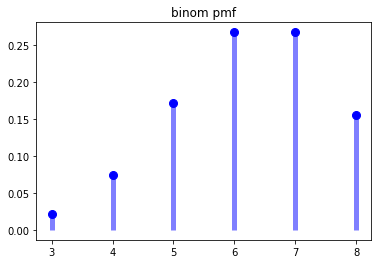

In [217]:
#####
from scipy.stats import binom
n=9
p=0.7
fig, ax = plt.subplots(1, 1)
x = np.arange(binom.ppf(0.01, n, p),binom.ppf(0.99, n, p))
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
plt.title("binom pmf")
plt.show()
################

For these particular values of $T$ and $p$, compute numerically $\mathbb P(g_n^T(X)=Y)$.

**Answer**

We have that $g_n^T(X)=Y$ if and only if the majority of base classifiers say that
$g_t(X)=Y$, that is if at least 5 of them say that.

In [83]:
def Succces_Probability(number_of_classifiers=[9],p=0.7):
    succes=[]
    for T in number_of_classifiers:
        
        probability=0.0
        middle=int(np.ceil(T/2))
        for k in range(middle,T+1):
            probability+=binom.pmf(k, n, p)
        succes.append(probability)
    return succes
print("Probabilty that g_n(X)=Y =",Succces_Probability([9],0.7))

Probabilty that g_n(X)=Y = [0.9011913399999991]


Plot the probability of success (or accuracy) with respect to the number of base classifiers for $p \in [0.55, 0.65, \dots, 0.95]$.
Be careful, the formula used previously is only valid for odd numbers of base classifiers.

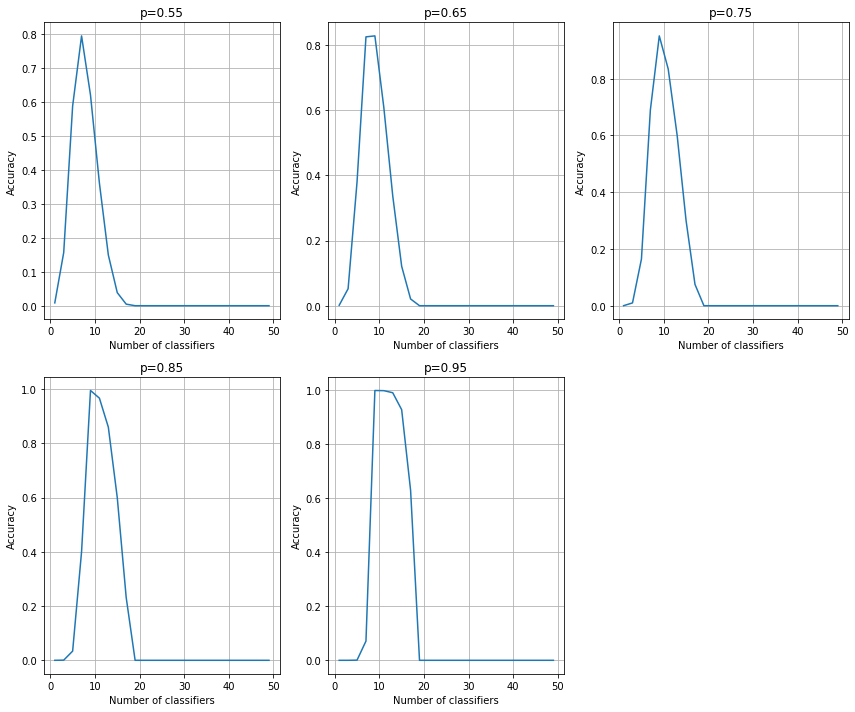

In [85]:
Ts = np.arange(1, 50, step=2)

plt.figure(figsize=(12, 10))
for it, p in enumerate(np.arange(0.55, 1, step=0.1)):
    ############# 
    ##  TO BE COMPLETED
    success = Succces_Probability(number_of_classifiers=Ts,p=p)
    ######
    plt.subplot(2, 3, it+1)
    plt.plot(Ts, success)
    plt.xlabel("Number of classifiers")
    plt.ylabel("Accuracy")
    plt.title("p={}".format(p))
    plt.grid()
plt.tight_layout()

Complete the following script to implement bagging with regression trees.

In [211]:
from sklearn.tree import DecisionTreeRegressor
class BaggingTree(DecisionTreeRegressor):
    def __init__(self, n_estimators=10, max_depth=1, max_samples=1.0):
        """
        Parameters:
        - n_estimators: number of estimators
        - max_depth: maximal depth of the regressor tree
        - max_samples: ratio of samples to use for learning base regressors.
            - If max_samples=1.0: use bootstrap.
            - If max_samples<1.0: use random sampling and extract max_samples x n points
            (where n is the total numer of points).
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_samples = max_samples
        
    def fit(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
            
        n = X.shape[0]  # Sample size
        m = int(self.max_samples * n)  # Number of points for random sampling
        
        self.estimators_ = []
        for t in range(self.n_estimators):
            if self.max_samples==1:
                idx = np.random.randint(low=0,high=n,size=n)  # Bootstrap
            else:
                #idx = np.random.permutation(int(self.max_samples*n))  # Random sampling
                idx = np.random.permutation(n)[:m] 
            self.estimators_.append(DecisionTreeRegressor(max_depth=depth))
            self.estimators_[-1].fit(X[idx],y[idx])
    
    def predict(self, X):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        
        y = [reg.predict(X) for reg in self.estimators_]
        return np.asarray(y)
    
    def error(self, X, y):
        # Make X a 2d-array
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        return np.sum((y - self.predict(X))**2)

Apply bagging to the following regression dataset and plot (on the same figure), the training data and the prediction for test data.

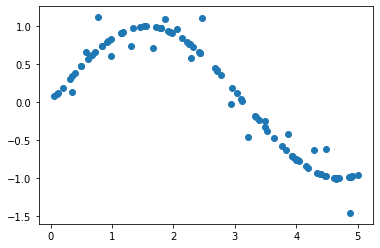

In [212]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)

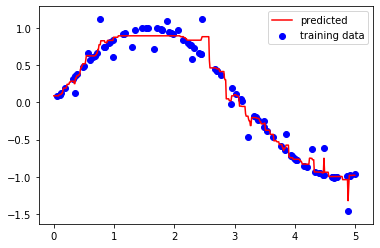

In [213]:
# TO BE COMPLETED
model=BaggingTree(n_estimators=10, max_depth=1, max_samples=1.0)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred=y_pred.mean(axis=0)
#print(X_test.shape)
y_pred=np.expand_dims(y_pred,axis=1)
#print(y_pred.shape)

#plot the prediction
plt.plot(X_test, y_pred,label="predicted",color="red")
plt.scatter(X_train, y_train,label="training data",color="blue")
plt.legend()



Analyze the behavior of the prediction curve and of the test error with respect to the maximal depth of decision trees and to the number of base regressors.

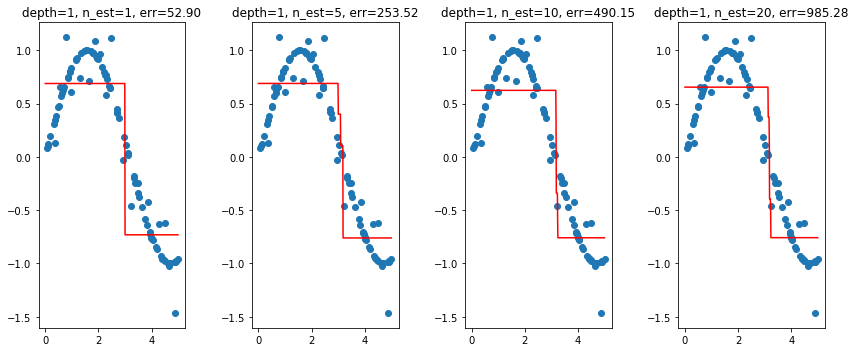

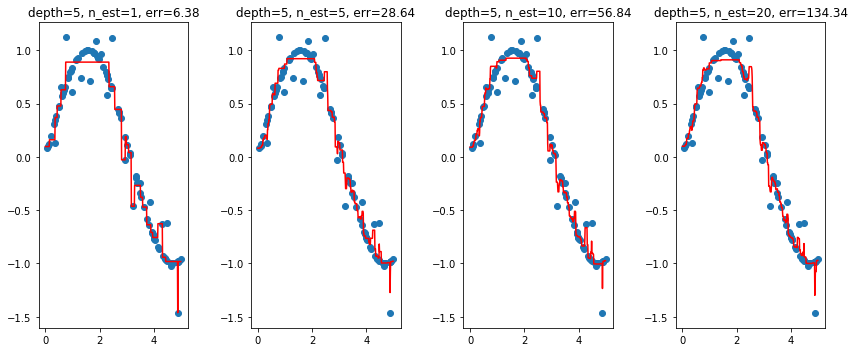

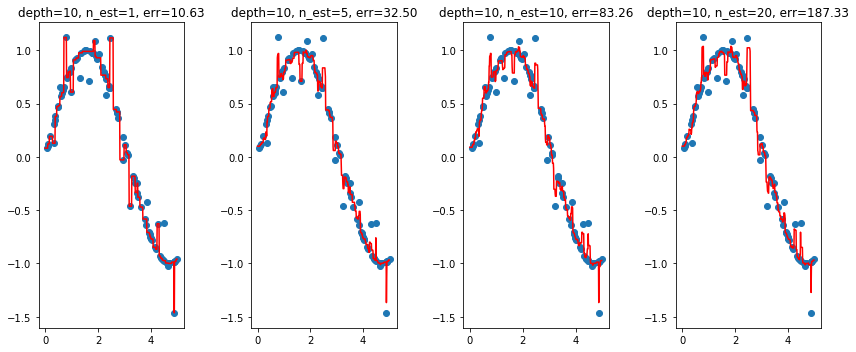

In [214]:
for depth in [1, 5, 10]:
    plt.figure(figsize=(12, 5))
    for it, T in enumerate([1, 5, 10, 20]):
        ########
        reg=BaggingTree(n_estimators=T, max_depth=depth, max_samples=1.0)
        reg.fit(X_train,y_train)
        y_pred=reg.predict(X_test)
        y_pred=y_pred.mean(axis=0)

        y_pred=np.expand_dims(y_pred,axis=1)
        ########
        plt.subplot(1, 4, it+1)
        plt.scatter(X_train, y_train)
        plt.plot(X_test, y_pred, 'r')
        plt.title("depth={0}, n_est={1}, err={2:0.2f}".format(depth, T,
                                                              reg.error(X_test, y_test)))
    plt.tight_layout()

We consider decision trees with *max\_depth = 5*.
Plot two curves (one with bootstrap and one with 25%-subsampling) showing the test error with respect to the number of base regressors.
What can we conclude?

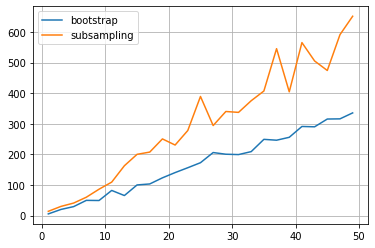

In [216]:
depth = 5

estim = np.arange(1, 50, step=2)
for name, reg in [("bootstrap", BaggingTree(max_depth=depth, max_samples=1)),
                  ("subsampling", BaggingTree(max_depth=depth, max_samples=0.25))]:
    error = []
    for T in estim:
    #########
        reg.n_estimators=T
        reg.fit(X_train,y_train)
        error.append(reg.error(X_test, y_test))
    #########
    plt.plot(estim, error, label=name)
plt.legend(loc="best")
plt.grid()

### Random forests

Random forests are bagged trees: for binary classification, a random forest is
$$
    g_n^T(x) = \operatorname{sign} \left( \frac{1}{T} \sum_{t=1}^T g_t(x) \right),
$$
where the base classifiers $(g_1, \dots, g_T)$, with $g_t \colon \mathbb R^d \to \{\pm 1\}$, are learned quasi-independently by bootstrap.

However, in order to enforce the independent learning, each decision tree $g_t$ owns an additional randomization step in its learning procedure:

1. at each cell, select a subset of features at random;
1. find the best pair (feature, threshold) for splitting.

The following script loads and preprocesses the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html).
Explain each step and indicate its purpose.

Is it useful for decision trees?

In [144]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler

data = load_diabetes()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler() # not necessary here 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

On the [diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html), compare scikit-learn [bagging](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) (with bootstrap and 25%-subsampling) and [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).
For this purpose, consider *max\_depth = 5* and plot three curves showing the regression score for the test set with respect to the number of base regressors.
What can we conclude?

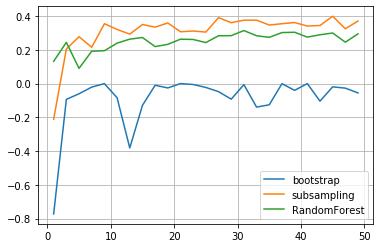

In [152]:
# Answer
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

depth = 5
params = {"max_depth": depth}

estim = np.arange(1, 50, step=2)
for name, reg in  [("bootstrap", BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',max_depth=depth)
                                                  , max_samples=1,bootstrap=True)),
                  ("subsampling", BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',max_depth=depth)
                      ,bootstrap=False, max_samples=0.25)),("RandomForest",
                                RandomForestRegressor(max_depth=depth))]:
    score = []
    for T in estim:
        reg.n_estimators = T
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)
plt.legend(loc="best")
plt.grid()

   ### Comparison between decision function, random forests, and extra trees
   
   
   We are going to compare 
   1. Decision function methods
   + Random forest
   + Extra trees
   
on the data sets that we already generated (moon / circles /linearly separable)

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

h = .02  # step size in the mesh

n_samples = 200
X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(79)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(n_samples=n_samples, noise=0.3, random_state=13),
            make_circles(n_samples=n_samples, noise=0.2, factor=0.5, random_state=17),
            linearly_separable
            ]


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The 

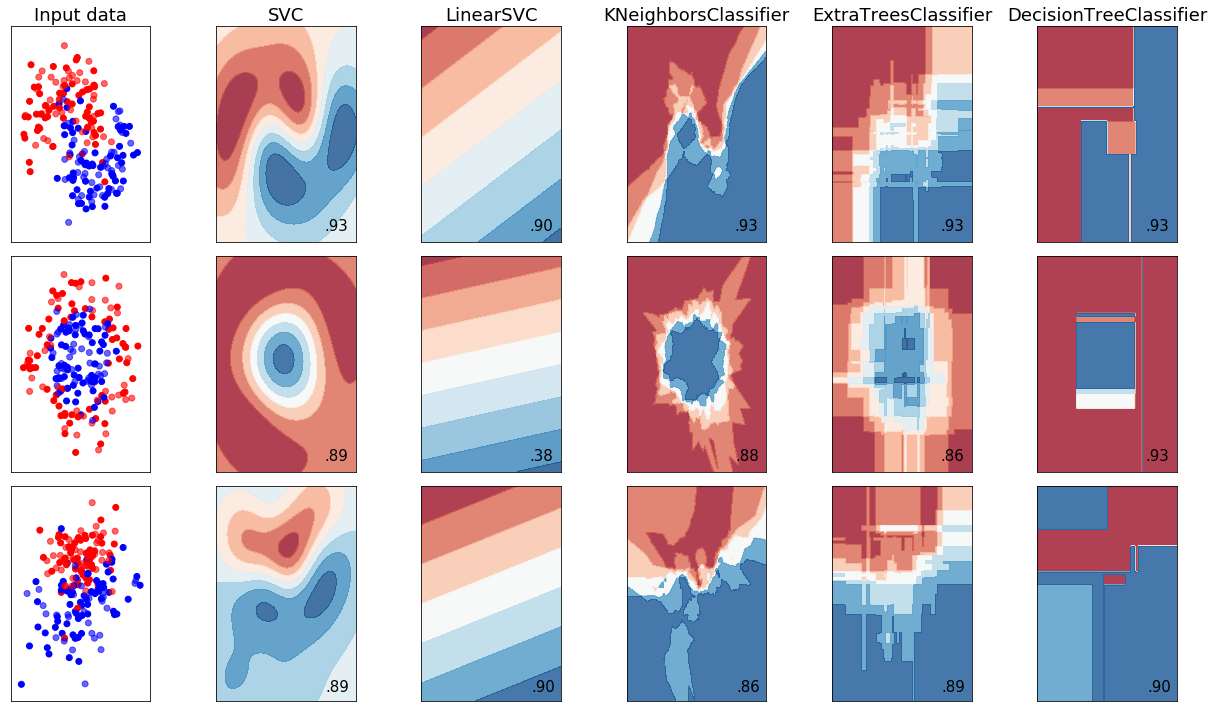

In [169]:
####### 
classifiers=[SVC(),LinearSVC(),KNeighborsClassifier(),ExtraTreesClassifier(max_depth=5),DecisionTreeClassifier(max_depth=5)]
names=["SVC","LinearSVC","KNeighborsClassifier","ExtraTreesClassifier","DecisionTreeClassifier"]
######

figure = plt.figure(figsize=(17, 10))
i = 1

# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", fontsize=18)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        #ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
        #           alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, fontsize=18)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()

### Model selection

Load the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits), split it randomly and preprocess it similarly to the diabetes dataset (be careful, we are now handling a classification dataset).

In [170]:
# Answer
from sklearn.datasets import load_digits

data = load_digits()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We aim at comparing three models based on the [digits classification dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits):
1. [gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html);
1. [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html);
1. [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

For each model, some possible values of parameters are defined below.
Explain the role of these parameters.

In [172]:
# Grid parameters
tree_params = {"max_depth": [5, 10, 15],
              "n_estimators": [10, 100]}  # Parameters for random forests
gb_params = tree_params.copy()  # Parameters for gradient boosting
gb_params.update({"learning_rate": np.logspace(-2, 0, num=3),
                 "max_features": [0.1]})
lr_params = {"C": np.logspace(-3, 3, num=7)}  # Parameters for logistic regression

With the training set previously generated, perform a [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) in order to determine "good" parameters among the ones proposed above.
Compare the test scores of the models trained with the "best" parameters.

In [173]:
# Auxiliary parameters
gs_params = {"cv": 3, "n_jobs": -1, "verbose": 1}

In [179]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



#Trees best parameters:
grid_search_trees = GridSearchCV(estimator =RandomForestClassifier() ,
                           param_grid = tree_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
grid_search_trees = grid_search_trees.fit(X_train, y_train)
best_parameters_trees = grid_search_trees.best_params_
best_accuracy_trees = grid_search_trees.best_score_
print("Trees best parameters:",best_parameters_trees)
print("Trees best accuracy:",best_accuracy_trees)

#Gradient boosting best parameters:
grid_search_gb = GridSearchCV(estimator =GradientBoostingClassifier() ,
                           param_grid = gb_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
grid_search_gb = grid_search_gb.fit(X_train, y_train)
best_parameters_gb = grid_search_gb.best_params_
best_accuracy_gb = grid_search_gb.best_score_
print("Gradient boosting best parameters:",best_parameters_gb)
print("Gradient bosting best accuracy:",best_accuracy_gb)


#Logistic Regression best parameters
grid_search_lr = GridSearchCV(estimator =LogisticRegression() ,
                           param_grid = lr_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
grid_search_lr = grid_search_lr.fit(X_train, y_train)
best_parameters_lr = grid_search_lr.best_params_
best_accuracy_lr = grid_search_lr.best_score_
print("Logistic Regression best parameters:",best_parameters_lr)
print("Logistic Regression best accuracy:",best_accuracy_lr)



Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.4s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9742519137091162
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   41.4s finished


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9742519137091162
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.9s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.954070981210856


In [ ]:

###


The general pattern of this numerical experiment is:
1. spliting randomly the dataset;
1. preprocessing it;
1. finding suitable parameters by grid search;
1. assessing the generalization error.

Repeat this experiment 20 times and record the score for each method and each run.
Print the mean score and the standard deviation for each method.

In [180]:
gs_params = {"cv": 3, "n_jobs": -1, "verbose": 0}

scores = []
for run in range(20):
    # Print
    print("Run", run)
    
    # Dataset
    X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    Trees = RandomForestClassifier()
    Trees.fit(X_train,y_train)
    gb = GradientBoostingClassifier()
    gb.fit(X_train,y_train)
    lr= LogisticRegression()
    lr.fit(X_train,y_train)
    
    
    # Score saving
    scores.append([Trees.score(X_test,y_test),gb.score(X_test,y_test),lr.score(X_test,y_test)])
    
    # Grid search 
    #Trees best parameters:
    grid_search_trees = GridSearchCV(estimator =RandomForestClassifier() ,
                           param_grid = tree_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
    grid_search_trees = grid_search_trees.fit(X_train, y_train)
    best_parameters_trees = grid_search_trees.best_params_
    best_accuracy_trees = grid_search_trees.best_score_
    print("Trees best parameters:",best_parameters_trees)
    print("Trees best accuracy:",best_accuracy_trees)
    
    
    #Gradient boosting best parameters:
    grid_search_gb = GridSearchCV(estimator =GradientBoostingClassifier() ,
                           param_grid = gb_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
    grid_search_gb = grid_search_gb.fit(X_train, y_train)
    best_parameters_gb = grid_search_gb.best_params_
    best_accuracy_gb = grid_search_gb.best_score_
    print("Gradient boosting best parameters:",best_parameters_gb)
    print("Gradient bosting best accuracy:",best_accuracy_gb)

    #Logistic Regression best parameters
    grid_search_lr = GridSearchCV(estimator =LogisticRegression() ,
                           param_grid = lr_params,
                           scoring = 'accuracy',
                           cv = 3,
                            n_jobs=-1,
                            verbose=1)
    grid_search_lr = grid_search_lr.fit(X_train, y_train)
    best_parameters_lr = grid_search_lr.best_params_
    best_accuracy_lr = grid_search_lr.best_score_
    print("Logistic Regression best parameters:",best_parameters_lr)
    print("Logistic Regression best accuracy:",best_accuracy_lr)


    
    #######

Run 0


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9707724425887265
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   47.6s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9707724425887265
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.953375086986778
Run 1


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9686847599164927
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   44.6s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9728601252609603
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    1.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9624217118997912
Run 2


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9728601252609603
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   48.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9756437021572721
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  21 | elapsed:    1.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.5s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.964509394572025
Run 3


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.8s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9735560194850382
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   43.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9756437021572721
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9582463465553236
Run 4


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9728601252609603
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   46.9s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9798190675017397
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.7s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9603340292275574
Run 5


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.0s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9686847599164927
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   46.5s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9728601252609603
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.3s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9589422407794015
Run 6


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9679888656924147
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9735560194850382
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.3s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9491997216423104
Run 7


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.9s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.965205288796103
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.8s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9672929714683368
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    2.0s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9561586638830898
Run 8


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.7s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9700765483646486
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   30.8s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9700765483646486
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.7s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9596381350034795
Run 9


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9742519137091162
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   25.3s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9735560194850382
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.7s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9568545581071677
Run 10


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.97633959638135
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9756437021572721
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9589422407794015
Run 11


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.964509394572025
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9686847599164927
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9568545581071677
Run 12


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.2s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9735560194850382
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   24.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.97633959638135
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.3s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9575504523312457
Run 13


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9659011830201809
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.6s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9686847599164927
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.2s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9568545581071677
Run 14


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9700765483646486
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.5s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9686847599164927
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 10.0}
Logistic Regression best accuracy: 0.9554627696590118
Run 15


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.2s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9693806541405706
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   21.5s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.97633959638135
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9638135003479471
Run 16


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.3s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9700765483646486
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   23.0s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9770354906054279
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9575504523312457
Run 17


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.2s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9665970772442589
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   20.9s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9700765483646486
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9561586638830898
Run 18


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.0s finished


Trees best parameters: {'max_depth': 10, 'n_estimators': 100}
Trees best accuracy: 0.9700765483646486
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   22.6s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.9735560194850382
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Logistic Regression best parameters: {'C': 1.0}
Logistic Regression best accuracy: 0.9624217118997912
Run 19


C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.2s finished


Trees best parameters: {'max_depth': 15, 'n_estimators': 100}
Trees best accuracy: 0.9700765483646486
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   21.7s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Gradient boosting best parameters: {'learning_rate': 0.01, 'max_depth': 15, 'max_features': 0.1, 'n_estimators': 100}
Gradient bosting best accuracy: 0.97633959638135
Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    1.4s finished
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Abdou\Anaconda3\envs\DataScience\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression best parameters: {'C': 10.0}
Logistic Regression best accuracy: 0.9603340292275574


In [181]:
# Answer
scores = np.asarray(scores)
print("\t{}\t{}\t{}".format("Gradient boosting", "Random forest", "Logistic regression"))
print("Mean\t{}\t{}\t{}".format(*scores.mean(axis=0)))
print("Std\t{}\t{}\t{}".format(*scores.std(axis=0)))

	Gradient boosting	Random forest	Logistic regression
Mean	0.9529166666666666	0.9649999999999996	0.9648611111111108
Std	0.009315914632074459	0.010518942349311932	0.008206206248179125


Perform a [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html) to assess the difference between the mean scores of Gradient boosting and random forests.

In [189]:
### 
mean_gb=scores[:,1]
mean_trees=scores[:,0]
d=mean_gb-mean_trees
from scipy.stats import wilcoxon
w,p=wilcoxon(d)
w,p
####

(3.0, 0.0003238158011629079)

Hence, we would reject the null hypothesis at a confidence level of 5%, concluding that there is no  difference between the mean scores of boosting and random forest